In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [32]:
data = torch.tensor(iris.drop(columns='species').values).float()

labels = torch.zeros(len(iris), dtype=torch.long)
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [36]:
class ANNiris(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

# INPUT LAYER

        self.layers['input'] = nn.Linear(4, nUnits)

# HIDDEN LAYER

        for i in range(nLayers):
            self.layers[f"hidden{i}"] = nn.Linear(nUnits, nUnits)

# OUTPUT LAYER

        self.layers["output"] = nn.Linear(nUnits, 3)

 
    def forward(self, x):

        x = self.layers['input'](x)

        for i in range(self.nLayers):
            x = F.relu( self.layers[f'hidden{i}'](x) )
        
        x = self.layers['output'](x)

        return x

In [37]:
nUnitsPerLayer = 12
nLayers = 4

net = ANNiris(nUnitsPerLayer, nLayers)

print(net)

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


In [56]:
def trainTheModel(theModel, numepochs):

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(theModel.parameters(),lr=.01)

  for epochi in range(numepochs):

    yHat = theModel(data)

    loss = lossfun(yHat,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = theModel(data)
  predlabels = torch.argmax(predictions,axis=1)
  acc = 100*torch.mean((predlabels == labels).float())

  nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)
  return acc,nParams

In [57]:
acc, nParams = trainTheModel(theModel=net, numepochs=2500)
print(acc.item())

98.0


In [ ]:
numLayers = range(1, 6)
numUnits = np.arange(4, 101, 3)

accuracies  = np.zeros((len(numUnits),len(numLayers)))
totalparams = np.zeros((len(numUnits),len(numLayers)))

for layer in range(len(numLayers)):
    for unit in range(len(numUnits)):
        net = ANNiris(numUnits[unit],numLayers[layer])
        acc, params = trainTheModel(net, numepochs=500)
        accuracies[unit,layer] = acc
        totalparams[unit,layer] = params



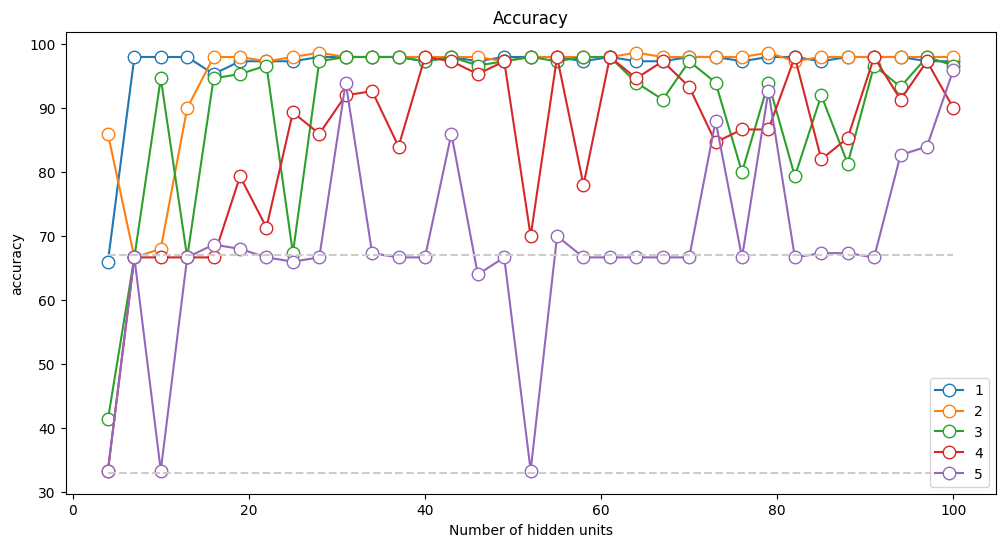

In [73]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(numUnits,accuracies,'o-',markerfacecolor='w',markersize=9)
ax.plot(numUnits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numUnits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(numLayers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

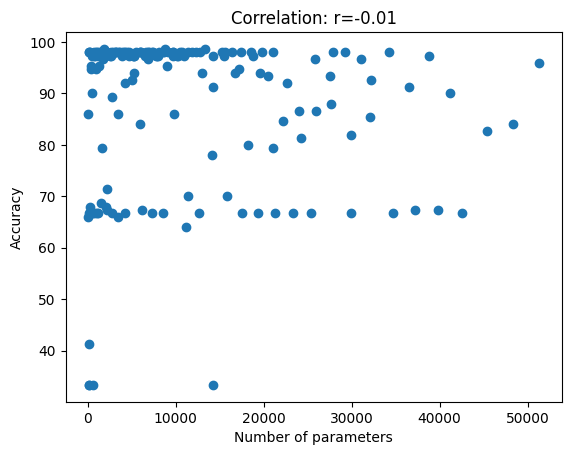

In [74]:
x = totalparams.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x,y)[0,1]

# scatter plot
plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r,3)))
plt.show()